## Gap Filling 

This notebook will show some algorithms to fill gaps of vector data and raster data. The notebook is structured as follows: 

1. Gap Filling of a vector dataset in spatial domain 
2. Gap filling of a raster dataset in temporal and spatial domain




In [1]:
import gridtools.gapfilling as gtg
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp
import xarray as xr
from xcube.core.store import new_data_store

To get access to the data, we will initiate the ESA CCI Zarr store in the following cell.

In [2]:
store = new_data_store('esa-cci-zarr')

--- 
### 1. Gap Filling of a Vector Dataset in the Spatial Domain

In this example, we will work with trend data of the Greenland ice sheet, which is provided as a set of spatial points over a given time range. We will apply several interpolation algorithms to fill the gaps between these points, ultimately converting the data into a raster format.

First we will open the data as usual. 

In [3]:
ds = store.open_data("ESACCI-ICESHEETS_Greenland_GMB-2003-2016-v1.1.zarr")
ds

<xarray.Dataset> Size: 43kB
Dimensions:     (meas_ind: 901, time: 10)
Dimensions without coordinates: meas_ind, time
Data variables:
    GMB_trend   (meas_ind, time) float32 36kB dask.array<chunksize=(901, 10), meta=np.ndarray>
    end_time    (time) datetime64[ns] 80B dask.array<chunksize=(10,), meta=np.ndarray>
    latitude    (meas_ind) float32 4kB dask.array<chunksize=(901,), meta=np.ndarray>
    longitude   (meas_ind) float32 4kB dask.array<chunksize=(901,), meta=np.ndarray>
    start_time  (time) datetime64[ns] 80B dask.array<chunksize=(10,), meta=np.ndarray>
    t           (time) datetime64[ns] 80B dask.array<chunksize=(10,), meta=np.ndarray>
Attributes: (12/20)
    Institution:          DTU Space - Div. of Geodynamics
    Latitude_max:         83.23728
    Latitude_min:         60.73857
    Longitude_max:        -14.706720000000018
    Longitude_min:        -71.83566000000002
    Method:               GRACE GMB trend following Barletta et al. 2012
    ...                   ...
    grid_projection:      Geographical coordinates relative to WGS84
    netCDF_version:       NETCDF3_CLASSIC
    product_version:      1.2
    time_coverage_end:    2016-01-31
    time_coverage_start:  2003-01-01
    time_resolution:      5Y

We define the final coordiates of the resired target raster and extract one time slice from the data set. 

In [4]:
lon = np.arange(-73., -12., 0.02)
lat = np.arange(83., 59., -0.02)
grid_lon, grid_lat = np.meshgrid(lon, lat)
GMB_trend_slice = ds.GMB_trend.isel(time=0)

Now we can perform a 2D linear interpolation using `scipy.interpolate.griddata`. 

In [5]:
gridded_data = interp.griddata(
    (ds.longitude, ds.latitude),
    GMB_trend_slice, 
    (grid_lon, grid_lat), 
    method='linear'
)
ds_linear = xr.Dataset(
    {'GMB_trend_slice': (['lat', 'lon'], gridded_data)},
    coords={'lon': lon, 'lat': lat}
)
ds_linear

<xarray.Dataset> Size: 29MB
Dimensions:          (lat: 1200, lon: 3050)
Coordinates:
  * lon              (lon) float64 24kB -73.0 -72.98 -72.96 ... -12.04 -12.02
  * lat              (lat) float64 10kB 83.0 82.98 82.96 ... 59.06 59.04 59.02
Data variables:
    GMB_trend_slice  (lat, lon) float64 29MB nan nan nan nan ... nan nan nan nan

The same approach can be applied using `"cubic"` as the interpolation method.

In [6]:
gridded_data = interp.griddata(
    (ds.longitude, ds.latitude),
    GMB_trend_slice, 
    (grid_lon, grid_lat), 
    method="cubic"
)
ds_cubic = xr.Dataset(
    {'GMB_trend_slice': (['lat', 'lon'], gridded_data)},
    coords={'lon': lon, 'lat': lat}
)
ds_cubic

<xarray.Dataset> Size: 29MB
Dimensions:          (lat: 1200, lon: 3050)
Coordinates:
  * lon              (lon) float64 24kB -73.0 -72.98 -72.96 ... -12.04 -12.02
  * lat              (lat) float64 10kB 83.0 82.98 82.96 ... 59.06 59.04 59.02
Data variables:
    GMB_trend_slice  (lat, lon) float64 29MB nan nan nan nan ... nan nan nan nan

Now, we can plot the results: the left plot shows the original points from the ESA CCI ice sheet trend dataset, the center plot displays the linear interpolation, and the right plot presents the cubic interpolation.

Text(0.5, 1.0, 'Cubic interpolation')

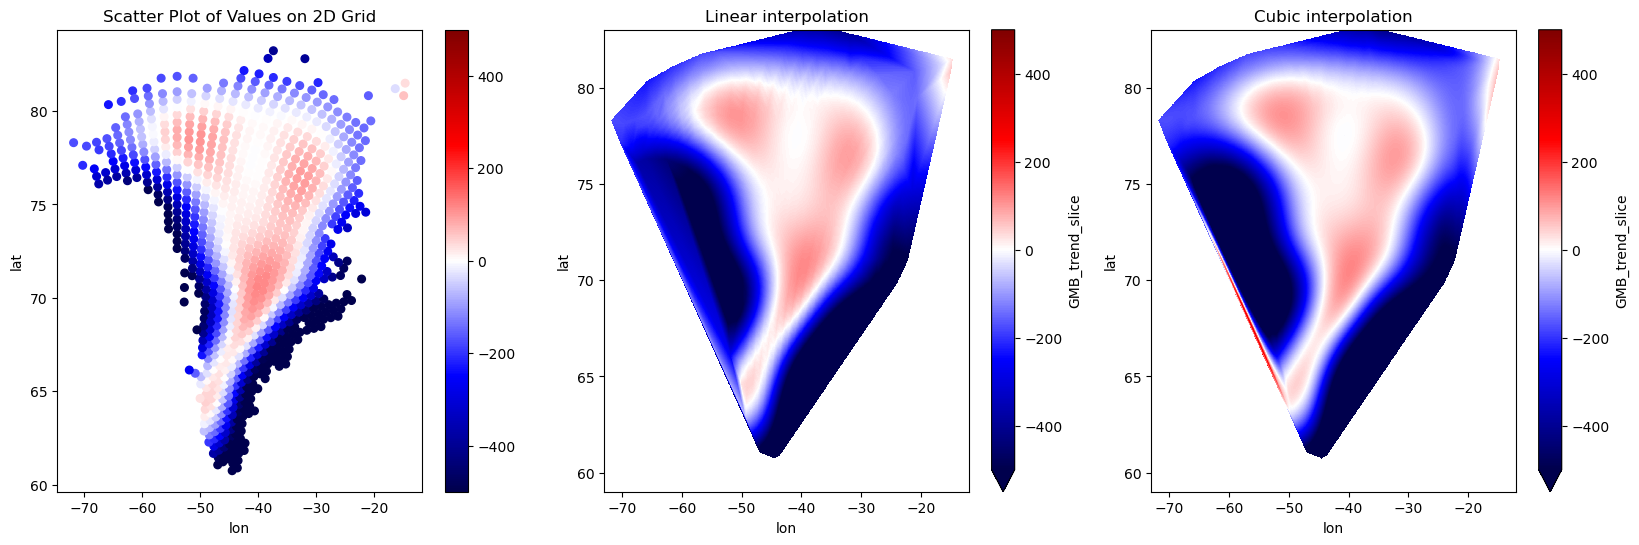

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
scatter = ax[0].scatter(
    ds.longitude, ds.latitude, c=GMB_trend_slice, cmap='seismic', vmin=-500, vmax=500, s=30
)
ax[0].set_title('Scatter Plot of Values on 2D Grid')
ax[0].set_ylabel('lat')
ax[0].set_xlabel('lon')
fig.colorbar(scatter, ax=ax[0], orientation='vertical')
ds_linear.GMB_trend_slice.plot(ax=ax[1], vmin=-500, vmax=500, cmap='seismic')
ax[1].set_title('Linear interpolation')
ds_cubic.GMB_trend_slice.plot(ax=ax[2], vmin=-500, vmax=500, cmap='seismic')
ax[2].set_title('Cubic interpolation')

#### Algorithms which are not working so fine -> I think we can delete this section!

In [8]:
from scipy.spatial import cKDTree

In [9]:
gridded_data = interp.griddata(
    (ds.longitude, ds.latitude),
    GMB_trend_slice, 
    (grid_lon, grid_lat), 
    method='nearest',
)
ds_nearest = xr.Dataset(
    {'GMB_trend_slice': (['lat', 'lon'], gridded_data)},
    coords={'lon': lon, 'lat': lat}
)
ds_nearest

<xarray.Dataset> Size: 29MB
Dimensions:          (lat: 1200, lon: 3050)
Coordinates:
  * lon              (lon) float64 24kB -73.0 -72.98 -72.96 ... -12.04 -12.02
  * lat              (lat) float64 10kB 83.0 82.98 82.96 ... 59.06 59.04 59.02
Data variables:
    GMB_trend_slice  (lat, lon) float64 29MB -174.3 -174.3 ... -518.7 -518.7

In [10]:
tree = cKDTree(np.vstack([ds.longitude, ds.latitude]).T)
dists, idxs = tree.query(np.vstack([grid_lon.ravel(), grid_lat.ravel()]).T, k=4)
weights = 1 / (dists ** 2)
weights /= weights.sum(axis=1, keepdims=True)
interpolated = (weights * GMB_trend_slice.values[idxs]).sum(axis=1).reshape(grid_lon.shape)

ds_idw = xr.Dataset(
    {'GMB_trend_slice': (['lat', 'lon'], gridded_data)},
    coords={'lon': lon, 'lat': lat}
)
ds_idw

<xarray.Dataset> Size: 29MB
Dimensions:          (lat: 1200, lon: 3050)
Coordinates:
  * lon              (lon) float64 24kB -73.0 -72.98 -72.96 ... -12.04 -12.02
  * lat              (lat) float64 10kB 83.0 82.98 82.96 ... 59.06 59.04 59.02
Data variables:
    GMB_trend_slice  (lat, lon) float64 29MB -174.3 -174.3 ... -518.7 -518.7

Text(0.5, 1.0, 'Inverse Distance Weighting interpolation')

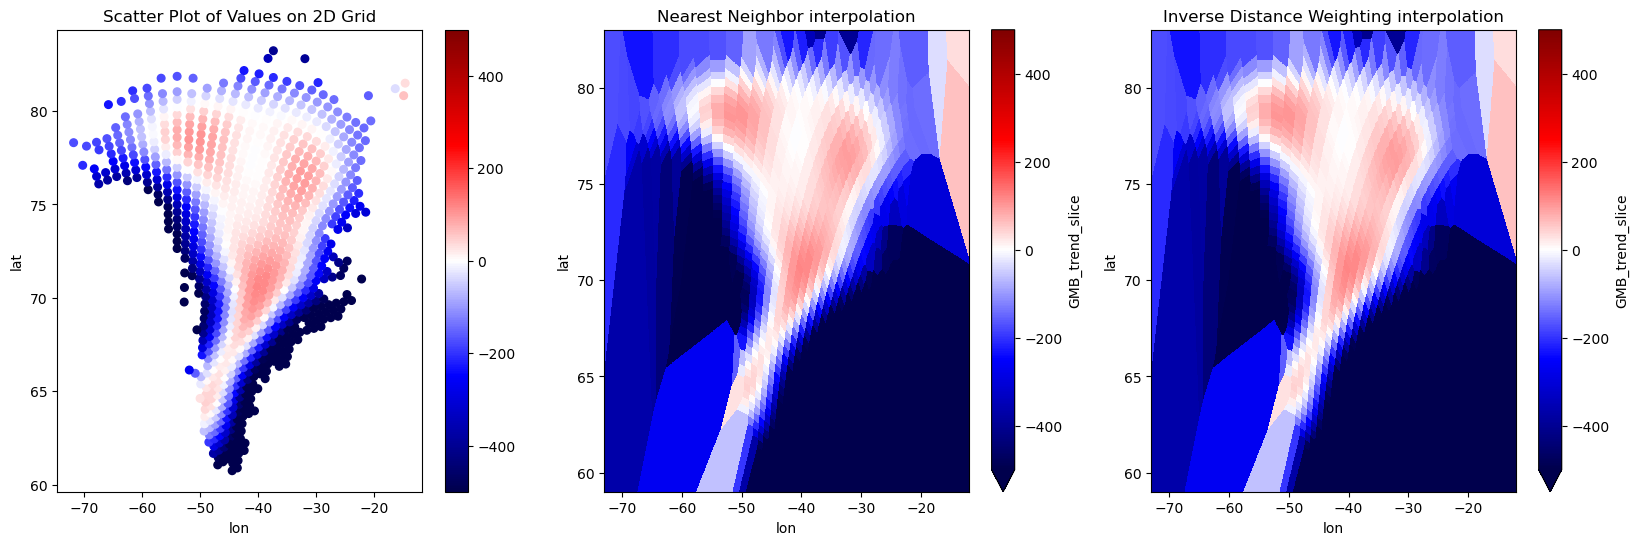

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
scatter = ax[0].scatter(
    ds.longitude, ds.latitude, c=GMB_trend_slice, cmap='seismic', vmin=-500, vmax=500, s=30
)
ax[0].set_title('Scatter Plot of Values on 2D Grid')
ax[0].set_ylabel('lat')
ax[0].set_xlabel('lon')
fig.colorbar(scatter, ax=ax[0], orientation='vertical')
ds_nearest.GMB_trend_slice.plot(ax=ax[1], vmin=-500, vmax=500, cmap='seismic')
ax[1].set_title('Nearest Neighbor interpolation')
ds_idw.GMB_trend_slice.plot(ax=ax[2], vmin=-500, vmax=500, cmap='seismic')
ax[2].set_title('Inverse Distance Weighting interpolation')

---
### 2. Gap filling of a raster dataset

In this example, we will work with the soil moisture dataset, which is a 3d rastered dataset with gaps in it. We will show an example how to fill the gaps along the time axis for a time series and how to fill the pags in the 2d spatial domain.  

First we will open the data as usual. 

In [12]:
ds = store.open_data('ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-1978-2021-fv07.1.zarr')
ds

<xarray.Dataset> Size: 654GB
Dimensions:         (time: 15767, lat: 720, lon: 1440)
Coordinates:
  * lat             (lat) float64 6kB 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * lon             (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time            (time) datetime64[ns] 126kB 1978-11-01 ... 2021-12-31
Data variables:
    dnflag          (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    flag            (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    freqbandID      (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    mode            (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    sensor          (time, lat, lon) float64 131GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    sm              (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    sm_uncertainty  (time, lat, lon) float32 65GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    t0              (time, lat, lon) float64 131GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                  CF-1.9
    cdm_data_type:                Grid
    comment:                      This dataset was produced with funding of t...
    contact:                      cci_sm_contact@eodc.eu
    creator_email:                cci_sm_developer@eodc.eu
    creator_name:                 Department of Geodesy and Geoinformation, V...
    ...                           ...
    time_coverage_end_product:    20211231T235959Z
    time_coverage_resolution:     P1D
    time_coverage_start:          1978-11-01 00:00:00
    time_coverage_start_product:  19781101T000000Z
    title:                        ESA CCI Surface Soil Moisture COMBINED acti...
    tracking_id:                  ad35798e-58e0-488f-b5b9-593874a47700

#### Gap filling along the time axis

For this, we create a small function that removes all NaN values and then performs interpolation to the original time axis using `xarray.Dataset.interp()`.


In [13]:
def fill_temporal_gaps(ds, method="linear"):
    new_times = ds_ts.time
    ds_nonans = ds_ts.dropna(dim="time")
    return ds_nonans.interp(time=new_times, method=method)

We will apply this gap-filling method to one year of the dataset as an example. To do this, we subset the dataset and select the year 2000.

In [14]:
ds_ts = ds.sel(lat=20, lon=20, method="nearest")
ds_ts = ds_ts.sel(time=slice('2000-01-01 00:00:00', '2001-01-01 00:00:00'))
ds_ts

<xarray.Dataset> Size: 18kB
Dimensions:         (time: 367)
Coordinates:
    lat             float64 8B 20.12
    lon             float64 8B 20.12
  * time            (time) datetime64[ns] 3kB 2000-01-01 ... 2001-01-01
Data variables:
    dnflag          (time) float32 1kB dask.array<chunksize=(13,), meta=np.ndarray>
    flag            (time) float32 1kB dask.array<chunksize=(13,), meta=np.ndarray>
    freqbandID      (time) float32 1kB dask.array<chunksize=(13,), meta=np.ndarray>
    mode            (time) float32 1kB dask.array<chunksize=(13,), meta=np.ndarray>
    sensor          (time) float64 3kB dask.array<chunksize=(13,), meta=np.ndarray>
    sm              (time) float32 1kB dask.array<chunksize=(13,), meta=np.ndarray>
    sm_uncertainty  (time) float32 1kB dask.array<chunksize=(13,), meta=np.ndarray>
    t0              (time) float64 3kB dask.array<chunksize=(13,), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                  CF-1.9
    cdm_data_type:                Grid
    comment:                      This dataset was produced with funding of t...
    contact:                      cci_sm_contact@eodc.eu
    creator_email:                cci_sm_developer@eodc.eu
    creator_name:                 Department of Geodesy and Geoinformation, V...
    ...                           ...
    time_coverage_end_product:    20211231T235959Z
    time_coverage_resolution:     P1D
    time_coverage_start:          1978-11-01 00:00:00
    time_coverage_start_product:  19781101T000000Z
    title:                        ESA CCI Surface Soil Moisture COMBINED acti...
    tracking_id:                  ad35798e-58e0-488f-b5b9-593874a47700

Next, we apply the gap-filling method to the selected sample.

In [15]:
ds_ts_gap_fill = fill_temporal_gaps(ds_ts)
ds_ts_gap_fill

<xarray.Dataset> Size: 18kB
Dimensions:         (time: 367)
Coordinates:
    lat             float64 8B 20.12
    lon             float64 8B 20.12
  * time            (time) datetime64[ns] 3kB 2000-01-01 ... 2001-01-01
Data variables:
    dnflag          (time) float32 1kB dask.array<chunksize=(367,), meta=np.ndarray>
    flag            (time) float32 1kB dask.array<chunksize=(367,), meta=np.ndarray>
    freqbandID      (time) float32 1kB dask.array<chunksize=(367,), meta=np.ndarray>
    mode            (time) float32 1kB dask.array<chunksize=(367,), meta=np.ndarray>
    sensor          (time) float64 3kB dask.array<chunksize=(367,), meta=np.ndarray>
    sm              (time) float32 1kB dask.array<chunksize=(367,), meta=np.ndarray>
    sm_uncertainty  (time) float32 1kB dask.array<chunksize=(367,), meta=np.ndarray>
    t0              (time) float64 3kB dask.array<chunksize=(367,), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                  CF-1.9
    cdm_data_type:                Grid
    comment:                      This dataset was produced with funding of t...
    contact:                      cci_sm_contact@eodc.eu
    creator_email:                cci_sm_developer@eodc.eu
    creator_name:                 Department of Geodesy and Geoinformation, V...
    ...                           ...
    time_coverage_end_product:    20211231T235959Z
    time_coverage_resolution:     P1D
    time_coverage_start:          1978-11-01 00:00:00
    time_coverage_start_product:  19781101T000000Z
    title:                        ESA CCI Surface Soil Moisture COMBINED acti...
    tracking_id:                  ad35798e-58e0-488f-b5b9-593874a47700

We then plot the original and gap-filled soil moisture dataset, zooming in on a two-month period to better highlight the gap-filling effect.  


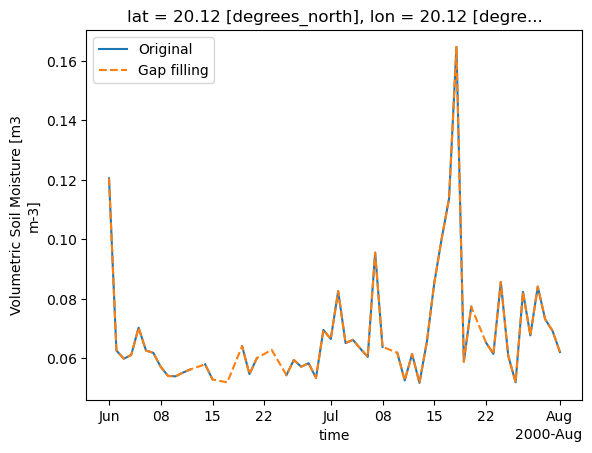

In [16]:
time_slice = slice('2000-06-01 00:00:00', '2000-08-01 00:00:00')
ds_ts.sm.sel(time=time_slice).plot(label="Original")
ds_ts_gap_fill.sm.sel(time=time_slice).plot(label="Gap filling", linestyle="dashed")
plt.legend()

#### Gap Filling in the Spatial Domain  

In this example, we utilize the low-pass gap-filling algorithm from [`gridtools`](https://github.com/esa-esdl/gridtools) (DOI [10.5281/zenodo.15062839](https://zenodo.org/records/15062840)). This method effectively applies a 2D low-pass filter to the data. As a demonstration, we select a single time slice and apply gap filling in the spatial domain using the aforementioned algorithm.  

In [17]:
sm_slice = ds.sm.sel(time='2000-07-01 12:00:00', method='nearest')
sm_slice

<xarray.DataArray 'sm' (lat: 720, lon: 1440)> Size: 4MB
dask.array<getitem, shape=(720, 1440), dtype=float32, chunksize=(720, 720), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 6kB 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
    time     datetime64[ns] 8B 2000-07-02
Attributes:
    _CoordinateAxes:      time lat lon
    ancillary_variables:  sm_uncertainty flag t0
    dtype:                float32
    long_name:            Volumetric Soil Moisture
    standard_name:        soil_moisture_content
    units:                m3 m-3
    valid_range:          [0.0, 1.0]

Next, we apply the gap-filling algorithm from `gridtools`, which is highly efficient as it leverages Numba for parallel computation. However, `gridtools` is not directly compatible with chunked Dask arrays. To overcome this, we can use Dask's `map_blocks` method, which applies a function to each chunk individually, as demonstrated below.  

In [18]:
def gridtools_lowpass(data):
    return gtg.fillgaps_lowpass_2d(data)

data_filled = sm_slice.data.map_blocks(gridtools_lowpass)
sm_slice_gridtools_lowpass = xr.DataArray(
    data_filled, 
    coords=sm_slice.coords, 
    dims=sm_slice.dims, 
    attrs=sm_slice.attrs,
    name='filled_data'
)
sm_slice_gridtools_lowpass

<xarray.DataArray 'filled_data' (lat: 720, lon: 1440)> Size: 4MB
dask.array<gridtools_lowpass, shape=(720, 1440), dtype=float32, chunksize=(720, 720), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 6kB 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
    time     datetime64[ns] 8B 2000-07-02
Attributes:
    _CoordinateAxes:      time lat lon
    ancillary_variables:  sm_uncertainty flag t0
    dtype:                float32
    long_name:            Volumetric Soil Moisture
    standard_name:        soil_moisture_content
    units:                m3 m-3
    valid_range:          [0.0, 1.0]

Finally, we plot the results for North Africa as an example to illustrate the gap-filling process.  

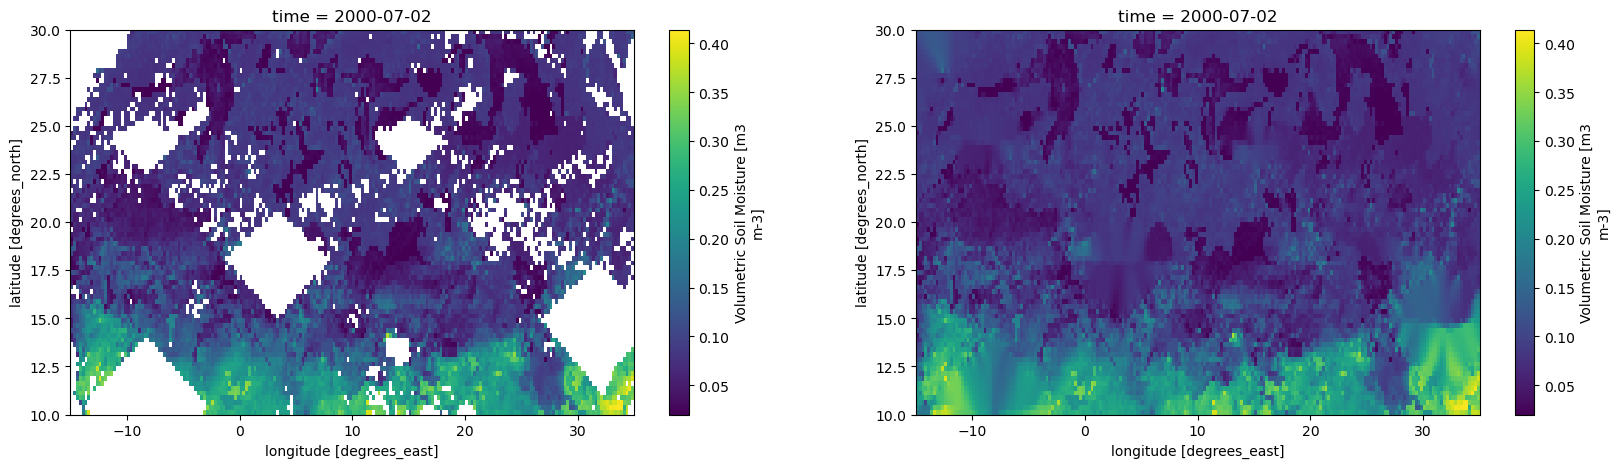

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
extent = dict(lat=slice(30, 10), lon=slice(-15, 35))
sm_slice.sel(**extent).plot(ax=ax[0])
sm_slice_gridtools_lowpass.sel(**extent).plot(ax=ax[1])